# Génération de données ECG avec VAEs

In [ ]:
# gpt Index
# gpt lama_

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.layers import Input, Conv2D, ELU, BatchNormalization, AveragePooling2D, Flatten, Dense, Lambda, Conv2DTranspose, UpSampling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Model
import datetime
from VAELossLayer import VariationalLossLayer
from SamplingLayer import SamplingLayer
from Preprocess import Preprocess
from BestModelCallback import BestModelCallback
from vae import VAE
from dvclive.keras import DVCLiveCallback
from scipy.signal import resample
from sklearn.model_selection import train_test_split



## Prétraitement des ECGs 

In [19]:
ECG_DIR = './xml_data/avril/' # ECG sous format xml
ECG_OUTPUT = './xml_data/ECG.H5' # ECG sous format hdf5
ecg_dataset = Preprocess(input_dir=ECG_DIR, output_file=ECG_OUTPUT)
ecg_dataset.xml_to_tensor()

with h5py.File(ECG_OUTPUT, 'r') as f:
        X_train = f['tracings'][:]

print(X_train.shape)
train_data =  X_train.reshape(X_train.shape + (1,))
print(train_data.shape)


(54, 400, 12)
(54, 400, 12)
(54, 400, 12, 1)


In [17]:
# with h5py.File('xml_data/ecg_tracings.hdf5', 'r') as f:
#         X_train = f['tracings'][:]

# print(X_train.shape)

# # Rééchantillonner le dataset
# X_train = resample(X_train, num=400, axis=1)

# # Vérifier la nouvelle dimension
# print(X_train.shape)  # Output: (827, 400, 12)


In [4]:
input_shape = (400,12,1)
print(X_train.shape)

data =  X_train.reshape(X_train.shape + (1,)) # to align with our input shape

# data = np.transpose(data, (0, 2, 1,3))
# print(data.shape)
print(data.shape)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(train_data.shape, test_data.shape)

(827, 400, 12)
(827, 400, 12, 1)
(661, 400, 12, 1) (166, 400, 12, 1)


## Architecture inspirée du cVAE 
### Cite :
Y. Sang, M. Beetz and V. Grau, "Generation of 12-Lead Electrocardiogram with Subject-Specific, Image-Derived Characteristics Using a Conditional Variational Autoencoder," 2022 IEEE 19th International Symposium on Biomedical Imaging (ISBI), Kolkata, India, 2022, pp. 1-5, doi: 10.1109/ISBI52829.2022.9761431.






In [5]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 32

In [6]:
# Encodeur

encoder_input = tf.keras.layers.Input(shape=(400, 12, 1), name='encoder_input')

conv_1 = tf.keras.layers.Conv2D(filters=5, kernel_size=(1, 400), padding='same', name='encoder_conv_layer_1')(encoder_input)
relu_1 = tf.keras.layers.ELU(name='encoder_relu_1')(conv_1)
bn_1 = tf.keras.layers.BatchNormalization(name='encoder_bn_1')(relu_1)

conv_2 = tf.keras.layers.Conv2D(filters=5, kernel_size=(1, 12), padding='same', name='encoder_conv_layer_2')(bn_1)
relu_2 = tf.keras.layers.ELU(name='encoder_relu_2')(conv_2)
bn_2 = tf.keras.layers.BatchNormalization(name='encoder_bn_2')(relu_2)

conv_3 = tf.keras.layers.Conv2D(filters=5, kernel_size=(1, 1), padding='same', strides=(1, 2), name='encoder_conv_layer_3')(bn_2)
relu_3 = tf.keras.layers.ELU(name='encoder_relu_3')(conv_3)
bn_3 = tf.keras.layers.BatchNormalization(name='encoder_bn_3')(relu_3)

flatten = tf.keras.layers.Flatten(name='flatten')(bn_3)
#dense = tf.keras.layers.Dense(units=1000)(flatten)
z_mean = Dense(LATENT_DIM, name="z_mean")(flatten)
z_log_var = Dense(LATENT_DIM, name="z_log_var")(flatten)
z = SamplingLayer()([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


2023-05-06 20:59:07.064680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
Colocations handled automatically by placer.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 400, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 400, 12, 5)   2005        ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ELU)           (None, 400, 12, 5)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 400, 12, 5)  20          ['encoder_relu_1[0][0]']   

In [7]:
# Décodeur
decoder_input = Input(shape=(LATENT_DIM,))
x = BatchNormalization()(decoder_input)

x = Dense(1200)(x)
x = Reshape((400, 3, 1))(x)
x = UpSampling2D(size=(1, 4))(x)

x = Conv2DTranspose(filters=1, kernel_size=(1, 5), strides=(1, 1), padding='same')(x)
x = ELU()(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(filters=1, kernel_size=(12, 1), strides=(1, 1), padding='same')(x)
x = ELU()(x)
x = BatchNormalization()(x)

decoder_outputs = x

decoder = Model(decoder_input, decoder_outputs, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1200)              39600     
                                                                 
 reshape (Reshape)           (None, 400, 3, 1)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 400, 12, 1)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 400, 12, 1)       6   

In [8]:
decoder_outputs.shape

TensorShape([None, 400, 12, 1])

In [9]:
# VAE
loss_weights  = [1,1]
outputs = decoder(z)

outputs = VariationalLossLayer(loss_weights=loss_weights)([encoder_input, z_mean, z_log_var, outputs])

vae = Model(encoder_input, outputs, name='vae')

vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 400, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 400, 12, 5)   2005        ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ELU)           (None, 400, 12, 5)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 400, 12, 5)  20          ['encoder_relu_1[0][0]']       

In [10]:
def create_tensorboard_callback(dir_name, experiment_name):
        log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir
        )
        print(f"Sauvegarde fichiers log dans: {log_dir}")
        return tensorboard_callback

In [11]:
train_data.shape

(661, 400, 12, 1)

In [20]:
vae.compile(optimizer='adam')
vae_history = vae.fit(
    train_data,
    batch_size=32,
    epochs=EPOCHS,
    callbacks=[                                                   
                create_tensorboard_callback(dir_name="callbacks", experiment_name="samedi_4_test"), 
                BestModelCallback('model/model_samedi_4.h5'),
                DVCLiveCallback(save_dvc_exp=True),
                ReduceLROnPlateau(
                    monitor='r_loss',
                    factor=0.1,
                    patience=10,
                    min_lr=LEARNING_RATE / 100)

                # EarlyStopping(patience=12,  
                #             min_delta=0.00001)
                                     ]
)

Sauvegarde fichiers log dans: callbacks/samedi_4_test/20230506-212003
Train on 54 samples


2023-05-06 21:20:05.494257: W tensorflow/c/c_api.cc:300] Operation '{name:'decoder/batch_normalization_2/AssignMovingAvg_1/AssignSubVariableOp' id:689 op device:{requested: '', assigned: ''} def:{{{node decoder/batch_normalization_2/AssignMovingAvg_1/AssignSubVariableOp}} = AssignSubVariableOp[_class=["loc:@batch_normalization_2/moving_variance"], _has_manual_control_dependencies=true, dtype=DT_FLOAT](batch_normalization_2/moving_variance, decoder/batch_normalization_2/AssignMovingAvg_1/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-06 21:20:05.936073: W tensorflow/c/c_api.cc:300] Operation '{name:'training_6/Adam/batch_normalization/beta/m/Assign' id:3113 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/batch_normalization/beta/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=

Epoch 1/100
32/54 [================>.............] - ETA: 0s - loss: nan - r_loss: nan - kl_loss: nan

2023-05-06 21:20:07.508405: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-05-06 21:20:07.508458: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


54/54 [==============================] - 2s 30ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 2/100


2023-05-06 21:20:07.857388: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-05-06 21:20:07.859893: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


54/54 [==============================] - 1s 25ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 1s 26ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 1s 27ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 5/100
54/54 [==============================] - 1s 27ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 6/100
54/54 [==============================] - 1s 26ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 7/100
54/54 [==============================] - 1s 27ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 8/100
54/54 [==============================] - 1s 23ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 9/100
54/54 [==============================] - 1s 26ms/sample - loss: nan - r_loss: nan - kl_loss: nan - lr: 0.0010
Epoch 10/100
54/54 [================

KeyboardInterrupt: 

In [84]:
model_test_1 = tf.keras.models.load_model('model/model_samedi_1.h5', custom_objects={'SamplingLayer': SamplingLayer, 'VariationalLossLayer':VariationalLossLayer})
model_test_2 = tf.keras.models.load_model('model/model_samedi_2.h5', custom_objects={'SamplingLayer': SamplingLayer, 'VariationalLossLayer':VariationalLossLayer})

# decoder_model = model_test.get_layer('decoder')

# latent_dim = 10 # la dimension de l'espace latent du modèle

# # Générer des vecteurs latents aléatoires de taille (10, latent_dim)
# z_sample = np.random.normal(size=(1, latent_dim))

# # Générer des données à partir des vecteurs latents
# generated_data = decoder.predict(z_sample)

# Afficher les valeurs de perte du modèle
# loss = vae.history.history['loss']
# r_loss = vae.history.history['r_loss']
# kl_loss = vae.history.history['kl_loss']

# print('Valeur de perte totale :', loss[-1])
# print('Valeur de perte de reconstruction :', r_loss[-1])
# print('Valeur de perte :', kl_loss[-1])


# Charger les données de test
# x_test = ...
# y_test = ...

# Calculer les valeurs de perte
loss_values = model_test_2.evaluate(train_data, train_data)

# Afficher les valeurs de perte
print('Loss:', loss_values[0])
print('r_loss:', loss_values[1])
print('kl_loss:', loss_values[2])


2/2 [==============================] - 1s 165ms/step - loss: 0.7474 - r_loss: 0.6775 - kl_loss: 0.0699
Loss: 0.7473880648612976
r_loss: 0.7473880648612976
kl_loss: 0.677464485168457


In [86]:

with h5py.File('xml_data/ecg_tracings.hdf5', 'r') as f:
        X_test = f['tracings'][:]

test_data_antonio =  X_test.reshape(X_train.shape + (1,)) # to align with our input shape
print(test_data_antonio.shape)

# Calculer les valeurs de perte
loss_values_test = model_test_1.evaluate(test_data_antonio, test_data_antonio)

# Afficher les valeurs de perte
print('Loss:', loss_values_test[0])
print('r_loss:', loss_values_test[1])
print('kl_loss:', loss_values_test[2])

(54, 400, 12, 1)
2/2 [==============================] - 1s 134ms/step - loss: 0.7252 - r_loss: 0.6811 - kl_loss: 0.0441
Loss: 0.7252025604248047
r_loss: 0.7252025604248047
kl_loss: 0.6810884475708008


In [68]:
from sklearn.decomposition import PCA

In [74]:
# Encoder les données en entrée dans l'espace latent
encoder = model_test.get_layer('encoder_relu_3')
x_test_encoded = encoder.predict(train_data, batch_size=BATCH_SIZE)

# Réduire la dimensionnalité de l'espace latent à l'aide de PCA
pca = PCA(n_components=5)
latent_space = pca.fit_transform(x_test_encoded)

# Afficher l'espace latent
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=train_data)
plt.colorbar()
plt.show()

AttributeError: 'ELU' object has no attribute 'predict'

In [58]:
def plot_metrics_curves(history):

    loss = history.history["loss"]
    r_loss = history.history["r_loss"]
    kl_loss = history.history["kl_loss"]

    epochs = range(len(history.history["loss"]))

    # Create a new figure and axis objects
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    # Plot the losses
    axs[0].plot(epochs, loss, label='training_loss', color='blue')
    axs[1].plot(epochs, r_loss, label='reconstruction_loss', color='red')
    axs[2].plot(epochs, kl_loss, label='kl_loss', color='orange')

    axs[0].set_title('Erreur totale')
    axs[0].legend()
    axs[1].set_title('Erreur de reconstruction')
    axs[1].legend()
    axs[2].set_title('Erreur de Kullback Leiber')
    axs[2].legend()

    

    # Show the plot
    plt.show()


plot_metrics_curves(model_test.history);


AttributeError: 'NoneType' object has no attribute 'history'

In [43]:
print(generated_data[0].shape)
print(generated_data.shape)
sample = generated_data[0]
print(sample.shape)

(1, 400, 1)
(1, 1, 400, 1)
(1, 400, 1)


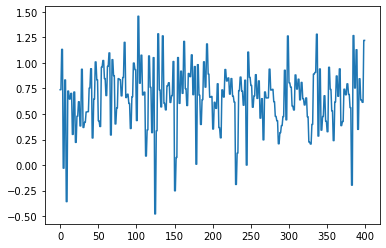

In [44]:
sample = sample.squeeze()

# Création d'un vecteur pour l'axe des x
x = np.arange(sample.shape[0])

# Tracé de la courbe
#fig, ax = plt.figure(1,1,figsize=(12,4))
plt.plot(x, sample)


In [3]:

    
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#     --name "EfficientNetB0 vs. ResNet50V2" \ 
#     --description "Comparaison de deux architectures différentes de modèles d'extraction de caractéristiques du Hub TF en utilisant 10% des images d'entraînement" \ 
#     --une_image

## Génération de données avec un GAN